# Anomaly and evaluation CHIRPS

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import dask.array as da
import dask
from dask.diagnostics import ProgressBar
import glob
import os
import math
import pandas as pd
from collections import Counter

### References

In [2]:
ds = xr.open_dataset('/home/jovyan/data/share/heloise/ESA-WP11/CHIRPS/nc_files/monthly_tp_1993_2016.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 288, lat: 1224, lon: 1032)
Coordinates:
  * lat      (lat) float64 -3.204 -3.213 -3.221 -3.229 ... -13.38 -13.39 -13.4
  * lon      (lon) float64 -82.0 -81.99 -81.98 -81.97 ... -73.42 -73.41 -73.4
  * time     (time) datetime64[ns] 1993-01-31 1993-02-28 ... 2016-12-31
Data variables:
    tp       (time, lat, lon) float32 ...

In [3]:
monthly_mean = ds.groupby('time.month').mean(dim='time')
monthly_mean

<xarray.Dataset>
Dimensions:  (month: 12, lat: 1224, lon: 1032)
Coordinates:
  * lat      (lat) float64 -3.204 -3.213 -3.221 -3.229 ... -13.38 -13.39 -13.4
  * lon      (lon) float64 -82.0 -81.99 -81.98 -81.97 ... -73.42 -73.41 -73.4
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tp       (month, lat, lon) float32 0.0 0.0 0.0 0.0 ... 153.3 136.5 134.3

In [3]:
def get_chirps_ref(ds):
    """
    Generate CHIRPS precipitation reference for each month.

    Parameters:
        ds (xarray.Dataset): A CHIRPS dataset containing precipitation data with a time dimension.

    """
    # Calculate the monthly mean of precipitation
    monthly_mean = ds.groupby('time.month').mean(dim='time')

    # Loop through each month to generate and save the reference data
    for month in range(1, 13):
        # Select the reference data for the current month
        month_ref = monthly_mean.isel(month=month - 1)

        # Plot and save the precipitation map for the current month
        month_ref.tp.plot(vmax=300)
        plt.title(f'Precipitation rate CHIRPS references in Northern Peru\n'
                  f'on the period 1993-2020\nMonth {month}', fontsize=12)
        frame = f'/home/jovyan/data/share/heloise/ESA-WP11/CHIRPS/figures/tp_ref_chirps_month_{month}.png'
        plt.savefig(frame)
        plt.show()
        plt.close()

        # Save the reference data as a NetCDF file
        month_ref.to_netcdf(f'/home/jovyan/data/share/heloise/ESA-WP11/CHIRPS/nc_files/tp_ref_chirps_month_{month}.nc')


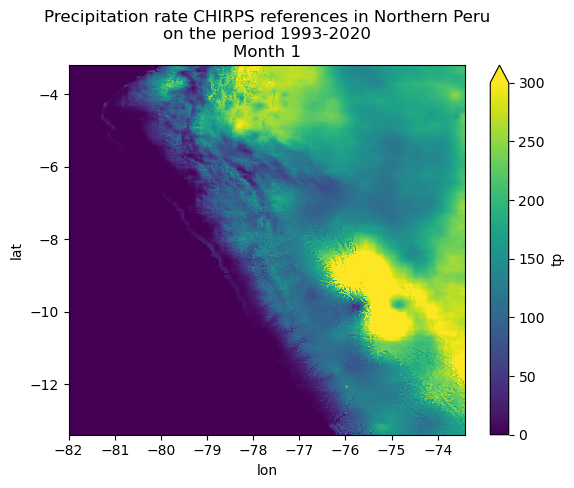

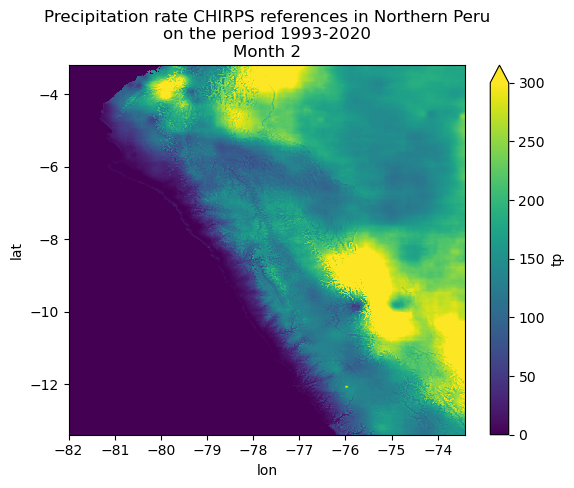

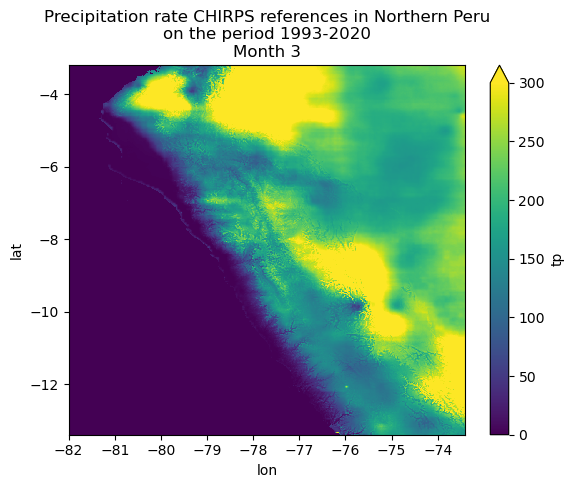

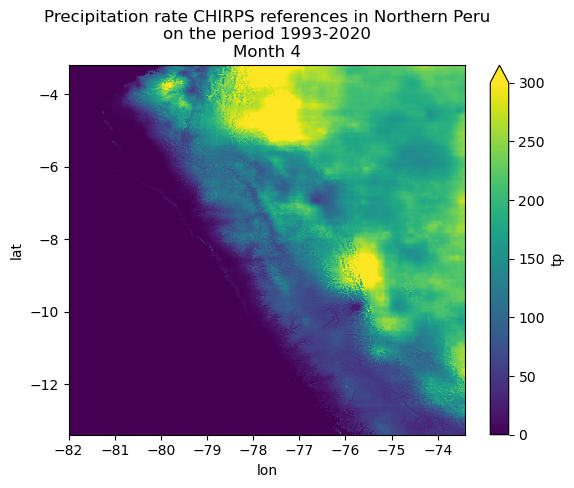

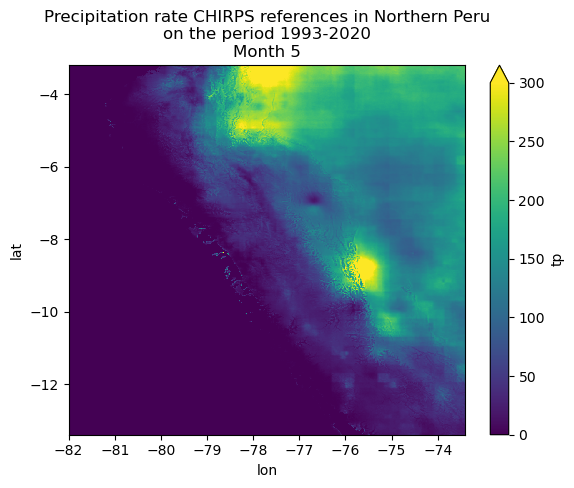

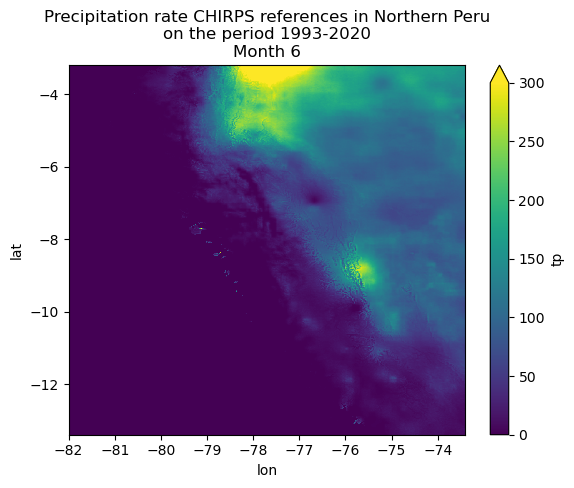

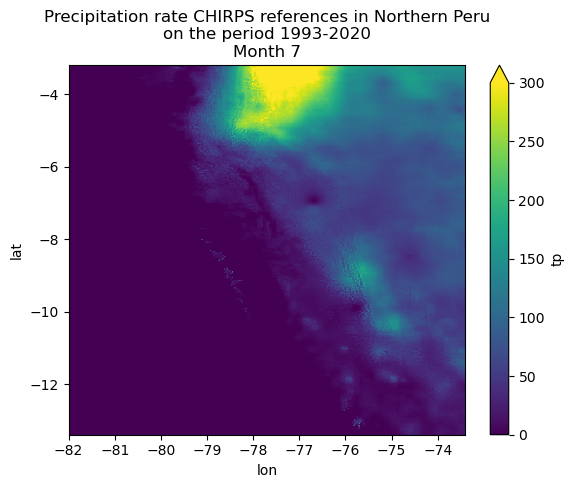

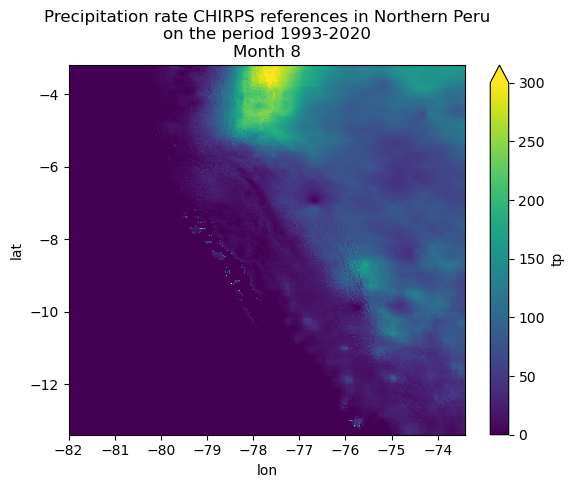

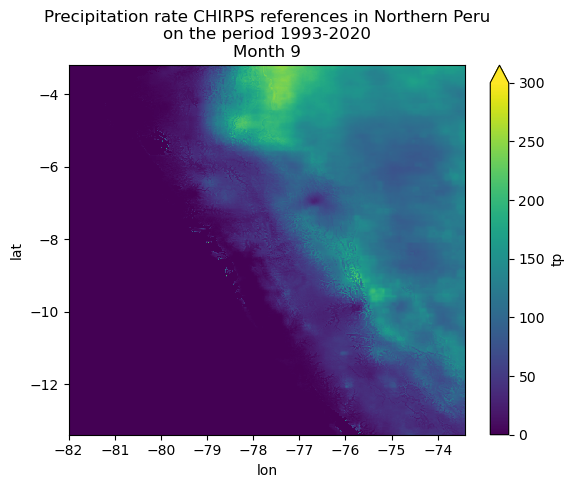

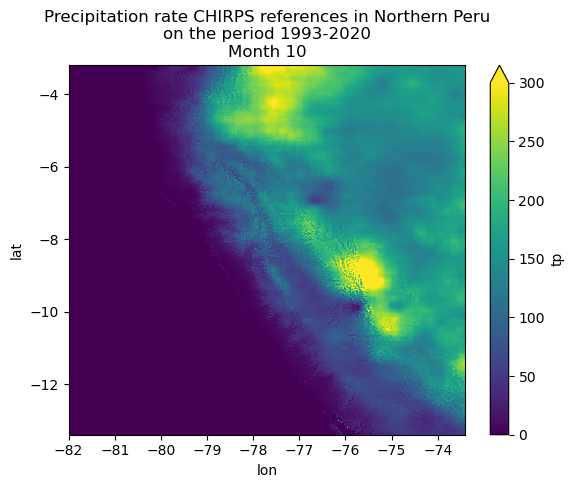

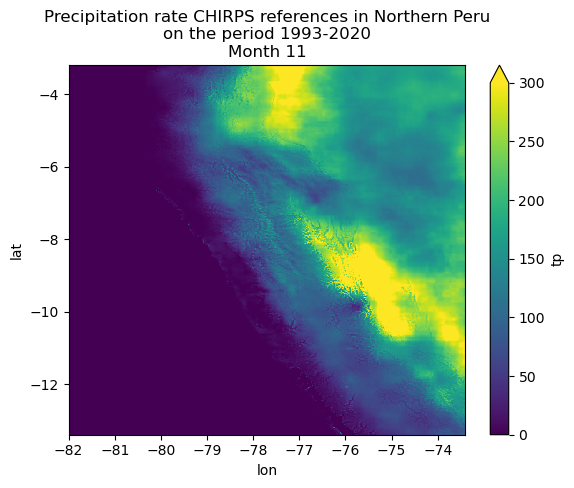

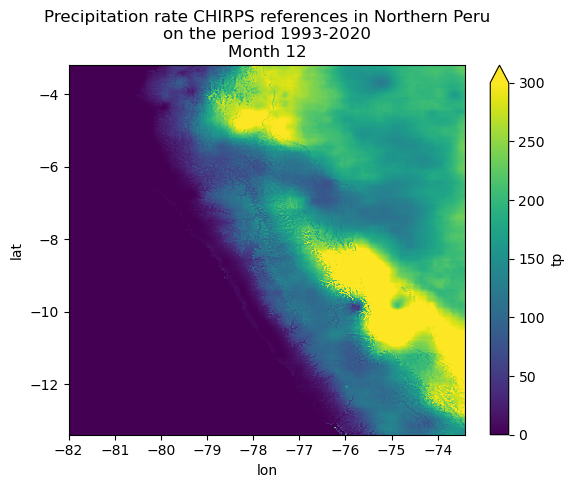

In [5]:
get_chirps_ref(ds)

### CHIRPS anomalies 

In [4]:
ds = xr.open_dataset('/home/jovyan/data/share/heloise/ESA-WP11/CHIRPS/nc_files/monthly_tp_2017_2020.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 48, lat: 1224, lon: 1032)
Coordinates:
  * lat      (lat) float64 -3.204 -3.213 -3.221 -3.229 ... -13.38 -13.39 -13.4
  * lon      (lon) float64 -82.0 -81.99 -81.98 -81.97 ... -73.42 -73.41 -73.4
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2020-12-31
Data variables:
    tp       (time, lat, lon) float32 ...

In [5]:
def generate_chirps_anomalies(ds, month: int = 1, year: int = 2017, type_an:str = 'absolute') -> xr.DataArray:
    """
    Generate total precipitation anomalies for a specific month and year.

    Parameters:
        month (int): Month for which to generate the anomalies (1-12).
        year (int): Year for which to generate the anomalies.
        type_an (str): Type of anomalies: 'absolute' or 'relative'.

    Returns:
        xr.DataArray: An array containing the total precipitation anomalies.

    """
    # Select the historical data for the specified year and month
    date =dt.datetime(year, month, 1)
    ds_month = ds.sel(time=(ds.time.dt.year == date.year) & (ds.time.dt.month == date.month))

    # Open the reference dataset for the corresponding month
    ref = xr.open_dataset(f'/home/jovyan/data/share/heloise/ESA-WP11/CHIRPS/nc_files/tp_ref_chirps_month_{month}.nc')

    if (type_an=='absolute'):
        # Calculate the absolute anomalies by subtracting the forecast data from the reference data
        anomalies = ds_month.tp - ref.tp
        # Set the attributes for the anomalies dataset
        anomalies.attrs['units'] = 'mm'
        anomalies.attrs['long_name'] = 'Total precipitation absolute anomaly'
    elif (type_an=='relative'):
        # Calculate the relative anomalies
        anomalies = ((ds_month.tp - ref.tp)/ref.tp)*100
        anomalies = anomalies.where(~((ref.tp == 0) & (ds_month.tp == 0)), 0)
        anomalies.attrs['units'] = '%'
        anomalies.attrs['long_name'] = 'Total precipitation relative anomaly'
    else:
        print("Please choose the type of anomaly: 'absolute' or 'relative'.")
        anomalies = None

    return anomalies


In [6]:
anom = generate_chirps_anomalies(ds, 5, 2018, 'relative')

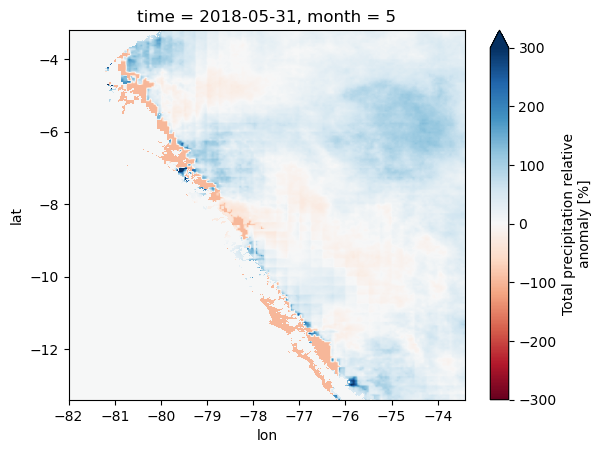

In [7]:
anom.plot(cmap = plt.cm.get_cmap('RdBu'), vmax=300)

In [10]:
lat_dam, lon_dam = -7.230 , -79.172
dam_anom = anom.sel(lat=lat_dam, lon=lon_dam, method='nearest')
dam_anom

<xarray.DataArray 'tp' (time: 1)>
array([0.], dtype=float32)
Coordinates:
    lat      float64 -7.229
    lon      float64 -79.17
  * time     (time) datetime64[ns] 2018-05-31
    month    int64 5
Attributes:
    units:      %
    long_name:  Total precipitation relative anomaly

### CHIRPS anomalies at the dam

In [8]:
def get_chirps_rel_anomaly_dam(ds, month: int = 1, year: int = 2017):
    
    anom = generate_chirps_anomalies(ds, month, year, 'relative')
    lat_dam, lon_dam = -7.230 , -79.172
    dam_anom = anom.sel(lat=lat_dam, lon=lon_dam, method='nearest')
    if (len(dam_anom)==0):
        dam = np.nan
    else :
        dam = dam_anom.values[0]
    
    return dam

In [9]:
get_chirps_rel_anomaly_dam(ds)

-7.140862

### C3S anomalies at the dam

In [4]:
def get_c3s_run_time(month:int = 1, downscaled:bool = True, hindcast:bool = False, forecast:bool = False) -> xr.Dataset:
    
    """
    Retrieve C3S ECMWF SEAS5 total precipitation data for a specific month.

    Parameters:
        month (int): Month value (1-12) for which to retrieve the data. Defaults to 1 (January).
        downscaled (bool): If True, retrieve the downscaled data. If False, retrieve the original forecast data.
                           Defaults to True.
        hindcast (bool): If True, filter the data to include only hindcast data within the range of 1993-01-01 to
                         2016-12-31. Applicable only when downscaled is True. Defaults to False.
        forecast (bool): If True, filter the data to include only forecast data starting from 2017-01-01.
                         Applicable only when downscaled is True. Defaults to False.

    Returns:
        xr.Dataset: Dataset containing the C3S ECMWF SEAS5 total precipitation data for the specified month.

    """
    
    start_date = np.datetime64(dt.datetime(1993, 1, 1))
    end_date = np.datetime64(dt.datetime(2016, 12, 31))
    forecast_start = np.datetime64(dt.datetime(2017, 1, 1))
    
    if downscaled:
        ds = xr.open_mfdataset(f'/home/jovyan/data/share/Martin/ESA/WP11/c3s_seasonal/downscaled/tp/peru_north/1km/method_002/*/{month:02d}/*.nc', preprocess=preprocess)
        if hindcast:
            ds = ds.sel(run_time=(ds.run_time >= start_date) & (ds.run_time <= end_date))
        if forecast:
            ds = ds.sel(run_time=(ds.run_time >= forecast_start))
    else:
        ds = xr.open_mfdataset( f'/home/jovyan/data/forecast/c3s_seasonal/peru_north/*/*/{month:02d}/*.nc', preprocess=preprocess)

    with ProgressBar():
        ds = ds.load()
        
    return ds


In [5]:
def preprocess(ds,downscaled:bool = True) -> xr.Dataset:
    
    """
    Preprocess the C3S ECMWF SEAS5 total precipitation dataset.

    Parameters:
        ds (xr.Dataset): Dataset containing the C3S ECMWF SEAS5 total precipitation data.
        downscaled (bool): If True, the dataset represents downscaled data. If False, it represents original forecast data.
                           Defaults to True.

    Returns:
        xr.Dataset: Preprocessed dataset.

    """
    
    if 'tprate' in list(ds.keys()):

        nb_days = ds.time.dt.days_in_month
        # m/s to mm/month
        conversion_factor = 1e3 * 3600 * 24

        # Apply conversion
        converted_ds = ds * conversion_factor * nb_days
        converted_ds.attrs["units"] = "mm"
        # rename latitude and longitude to lat /lon (WF format)
        converted_ds = standardize_coordinates(converted_ds)

        # rename variable to tp
        ds = converted_ds.rename_vars(name_dict={'tprate': 'tp'})        
    
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        run_time = ds.indexes["time"][0]
        ds = ds.assign_coords({"run_time": run_time})
        ds = ds.expand_dims("run_time")
        ds = ds.assign_coords({"time": [i for i in range(1, 7)]})
        #ds = ds.assign_coords({"offset": ("time", [f"{i}MS" for i in range(6)])})
        ds = ds.rename({"time": "lead_time"})
        # put negative values to zeros
        ds['tp'] = xr.where(ds['tp'] < 0, 0, ds['tp'])

    return ds

In [6]:
def get_c3s_rel_anomalies_dam(year: int = 2018, month: int = 1) -> xr.DataArray:
    """
    Generate relative precipitation anomalies for a specific month and year at the dam location.

    Parameters:
        month (int): Month for which to generate the anomalies (1-12).
        year (int): Year for which to generate the anomalies.

    Returns:
        xr.DataArray: An array containing the total precipitation anomalies.

    """
    lat_dam, lon_dam = -7.230 , -79.172

    # Get the C3S ECMWF SEAS5 forecast dataset for the specified month
    if (year >= 2017):
        ds = get_c3s_run_time(month, downscaled=True, forecast=True)
    else:
        ds = get_c3s_run_time(month, downscaled=True, hindcast=True)


    # Select the forecast data for the specified year and month
    runtime = np.datetime64(dt.datetime(year, month, 1))
    ds_t = ds.sel(run_time=(ds.run_time == runtime))
    ds_t_dam = ds_t.sel(lat=lat_dam, lon=lon_dam, method='nearest')
    
    # Open the reference dataset for the corresponding month
    ref = xr.open_dataset(f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/c3s_ref/tp_ref_c3s_hindcast_month_{month}_1993_2016.nc')
    ref_dam = ref.sel(lat=lat_dam, lon=lon_dam, method='nearest')
    
    
    # Calculate the relative anomalies
    anomalies = ((ds_t_dam.tp - ref_dam.tp)/ref_dam.tp)*100
    anomalies.attrs['units'] = '%'
    anomalies.attrs['long_name'] = 'Total precipitation relative anomaly'
    

    return anomalies[0]


In [16]:
get_c3s_rel_anomalies_dam()

[########################################] | 100% Completed | 2.04 sms


<xarray.DataArray 'tp' (lead_time: 6)>
array([15.34220084, -1.7478713 ,  2.0544829 , -0.42449206, -0.95118505,
       -2.16695007])
Coordinates:
    lat        float64 -7.229
    lon        float64 -79.17
  * lead_time  (lead_time) int64 1 2 3 4 5 6
    run_time   datetime64[ns] 2018-01-01
Attributes:
    units:      %
    long_name:  Total precipitation relative anomaly

### Comparison C3S-CHIRPS

In [11]:
year = 1993
month = 1

In [12]:
ds_chirps_1 = xr.open_dataset('/home/jovyan/data/share/heloise/ESA-WP11/CHIRPS/nc_files/monthly_tp_1993_2016.nc')
ds_chirps_2 = xr.open_dataset('/home/jovyan/data/share/heloise/ESA-WP11/CHIRPS/nc_files/monthly_tp_2017_2021.nc')
ds_combined = xr.concat([ds_chirps_1, ds_chirps_2], dim='time') 
get_chirps_rel_anomaly_dam(ds_combined, month, year)

-12.135381

In [8]:
# Open the datasets
ds_chirps_1 = xr.open_dataset('/home/jovyan/data/share/heloise/ESA-WP11/CHIRPS/nc_files/monthly_tp_1993_2016.nc')
ds_chirps_2 = xr.open_dataset('/home/jovyan/data/share/heloise/ESA-WP11/CHIRPS/nc_files/monthly_tp_2017_2020.nc')

# Combine the datasets into a single DataArray
ds_combined = xr.concat([ds_chirps_1, ds_chirps_2], dim='time')

# Print the combined DataArray
print(ds_combined)


<xarray.Dataset>
Dimensions:  (time: 336, lat: 1224, lon: 1032)
Coordinates:
  * lat      (lat) float64 -3.204 -3.213 -3.221 -3.229 ... -13.38 -13.39 -13.4
  * lon      (lon) float64 -82.0 -81.99 -81.98 -81.97 ... -73.42 -73.41 -73.4
  * time     (time) datetime64[ns] 1993-01-31 1993-02-28 ... 2020-12-31
Data variables:
    tp       (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 149.5 133.8 132.5


In [9]:
def generate_anomalies_comparison():
    """
    Generate a comparison of relative anomalies between C3S and CHIRPS datasets.
    """
    anomalies = []
    # Open the datasets
    ds_chirps_1 = xr.open_dataset('/home/jovyan/data/share/heloise/ESA-WP11/CHIRPS/nc_files/monthly_tp_1993_2016.nc')
    ds_chirps_2 = xr.open_dataset('/home/jovyan/data/share/heloise/ESA-WP11/CHIRPS/nc_files/monthly_tp_2017_2021.nc')

    # Combine the datasets into a single DataArray
    ds_combined = xr.concat([ds_chirps_1, ds_chirps_2], dim='time')

    for year in range(2000, 2021):
        for month in range(1, 13):
            print(year, month)
            # Get the CHIRPS anomalies for the specific year and month
            anom_obs = get_chirps_rel_anomaly_dam(ds_combined, month, year)

            leads = []                
            min_diff = float('inf')
            min_index = None

            for k in range(1, 6):

                if month > k:
                    runtime = month - k
                    year_k = year
                else:
                    runtime = 12 + (month - k)
                    year_k = year - 1

                lead = k
                # Get the C3S anomalies for the corresponding runtime and lead time
                anom_model = get_c3s_rel_anomalies_dam(year_k, runtime)
                leads.append(anom_model.values[k]) # k is the lead time

                # best lead
                diff = abs(anom_obs - float(leads[k-1]))
                if diff < min_diff:
                    min_diff = diff
                    min_index = k

            # leads okay
            leads_good = True
            good_lead_index = None

            #threshold = 0.5 * an_gsod_t

            # Find the index of the last lead time where the condition is met
            for k, lead_value in enumerate(leads):
                #if (an_gsod_t > 0 and float(lead_value) < threshold) or (an_gsod_t < 0 and float(lead_value) > threshold):
                if (math.isnan(anom_obs)) or (anom_obs > 0 and float(lead_value) < 0) or (anom_obs < 0 and float(lead_value) > 0):
                    leads_good = False
                    break
                good_lead_index = k + 1

            print(anom_obs)
            anomalies.append({'year': year, 'month': month, 'anomaly_chirps_rel (%)': anom_obs, 'anomaly_c3s_rel_leads_1_5 (%)': leads, 'good_sign_lead': good_lead_index, 'best_lead': min_index, 'diff (%)': min_diff})

    df_anomalies = pd.DataFrame(anomalies)
    df_anomalies.to_csv('/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/anomalies_compared_c3s_chirps_p2.csv')


In [ ]:
generate_anomalies_comparison()

In [13]:
file1 = '/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/anomalies_compared_c3s_chirps_p1.csv'
file2 = '/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/anomalies_compared_c3s_chirps_p2.csv'
files = [file1, file2]
df = pd.DataFrame()

for file in files:
    data = pd.read_csv(file)
    df = pd.concat([df, data], axis=0)

# Resetting the index to ensure unique indices
df.reset_index(drop=True, inplace=True)

df.to_csv('/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/anomalies_compared_c3s_chirps.csv')

In [51]:
# Read the C3S anomalies data
df = pd.read_csv('/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/anomalies_compared_c3s_chirps.csv')
    
rain, rain_detected = 0, 0
no_rain , no_rain_detected = 0, 0
rain_good_lead, no_rain_good_lead = [], []

for index, q in enumerate(df['anomaly_chirps_rel (%)']):
    value = df.good_sign_lead[index]
    
    if (q > 0) :
        rain = rain + 1
        if (not math.isnan(value)):
            rain_detected = rain_detected + 1
            rain_good_lead.append(value)
    elif (q < 0) :
        no_rain = no_rain + 1
        if (not math.isnan(value)):
            no_rain_detected = no_rain_detected + 1
            no_rain_good_lead.append(value)

# Calculate the most common lead time for both positive and negative anomalies
rain_count = Counter(rain_good_lead)
rain_maj_lead = rain_count.most_common(1)[0][0]
no_rain_count = Counter(no_rain_good_lead)
no_rain_maj_lead = no_rain_count.most_common(1)[0][0]

# Print the results
print(f'Positive precipitation detected {rain_detected} times over {rain}, ie {rain_detected/rain * 100:.2f}%.')
print(f'Most of the time, it is detected up to month + {rain_maj_lead}.\n')
print(f'Negative precipitation detected {no_rain_detected} times over {no_rain}, ie {no_rain_detected/no_rain * 100:.2f}%.')
print(f'Most of the time, it is detected up to month + {no_rain_maj_lead}.')


Positive precipitation detected 39 times over 81, ie 48.15%.
Most of the time, it is detected up to month + 5.0.

Negative precipitation detected 71 times over 108, ie 65.74%.
Most of the time, it is detected up to month + 5.0.


In [61]:
import pandas as pd
import math
from collections import Counter

# Read the C3S anomalies data
df = pd.read_csv('/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/anomalies_compared_c3s_chirps.csv')

rain, rain_detected = 0, 0
less_rain , less_rain_detected = 0, 0
no_rain , no_rain_detected = 0, 0
rain_good_lead, less_rain_good_lead, no_rain_good_lead = [], [], []

threshold = 20

for index, row in df.iterrows():
    value = row['good_sign_lead']
    q = row['anomaly_chirps_rel (%)']
    q_leads = row['anomaly_c3s_rel_leads_1_5 (%)']

    if q > threshold:
        rain += 1
        if not math.isnan(value):
            rain_detected += 1
            rain_good_lead.append(value)
    elif q < -threshold:
        less_rain += 1
        if not math.isnan(value):
            less_rain_detected += 1
            less_rain_good_lead.append(value)
    else:
        no_rain += 1
        if (float(q_leads[1:7]) <= threshold) and (float(q_leads[1:7]) >= -threshold):
            no_rain_detected += 1         

rain_count = Counter(rain_good_lead)
rain_maj_lead = rain_count.most_common(1)[0][0]
less_rain_count = Counter(less_rain_good_lead)
less_rain_maj_lead = less_rain_count.most_common(1)[0][0]

print(f'Positive precipitation detected {rain_detected} times over {rain}, i.e., {rain_detected/rain * 100:.2f}%.')
print(f'Most of the time, it is detected up to month + {rain_maj_lead}.\n')
print(f'Negative precipitation detected {less_rain_detected} times over {less_rain}, i.e., {less_rain_detected/less_rain * 100:.2f}%.')
print(f'Most of the time, it is detected up to month + {less_rain_maj_lead}.\n')
print(f'No anomaly of precipitation detected {no_rain_detected} times over {no_rain}, i.e., {ratio * 100:.2f}%.')

Positive precipitation detected 26 times over 52, i.e., 50.00%.
Most of the time, it is detected up to month + 5.0.

Negative precipitation detected 45 times over 70, i.e., 64.29%.
Most of the time, it is detected up to month + 5.0.

No anomaly of precipitation detected 87 times over 202, i.e., 28.57%.


Same but for each month

In [47]:
# Read the C3S anomalies data
df = pd.read_csv('/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/anomalies_compared_c3s_chirps.csv')

# Group data by month
monthly_groups = df.groupby('month')

for month, group in monthly_groups:
    rain, rain_detected = 0, 0
    less_rain , less_rain_detected = 0, 0
    no_rain , no_rain_detected = 0, 0
    rain_good_lead, less_rain_good_lead = [], []

    for index, row in group.iterrows():
        value = row['good_sign_lead']
        q = row['anomaly_chirps_rel (%)']
        q_leads = row['anomaly_c3s_rel_leads_1_5 (%)']
        
        threshold = 10
        
        if q > threshold:
            rain += 1
            if not math.isnan(value):
                rain_detected += 1
                rain_good_lead.append(value)
        elif q < -threshold:
            less_rain += 1
            if not math.isnan(value):
                less_rain_detected += 1
                less_rain_good_lead.append(value)
        else:
            no_rain += 1
            if (float(q_leads[1:6]) <= threshold) & (float(q_leads[1:6])>= -threshold):
                no_rain_detected += 1                

    rain_count = Counter(rain_good_lead)
    less_rain_count = Counter(less_rain_good_lead)
    no_rain_count = Counter(no_rain_good_lead)

    if rain_good_lead:
        rain_maj_lead = rain_count.most_common(1)[0][0]
        print(f"Results for Month {month} (Rain):")
        print(f'Positive precipitation anomaly detected {rain_detected} times over {rain}, i.e., {rain_detected/rain * 100:.2f}%.')
        print(f'Most of the time, it is detected up to month + {rain_maj_lead}.')
    else:
        print(f"No positive precipitation anomaly data for Month {month}.")

    
    if less_rain_good_lead:
        less_rain_maj_lead = no_rain_count.most_common(1)[0][0]
        print(f"Results for Month {month} (Less Rain):")
        print(f'Negative precipitation anomaly detected {less_rain_detected} times over {less_rain}, i.e., {less_rain_detected/less_rain * 100:.2f}%.')
        print(f'Most of the time, it is detected up to month + {less_rain_maj_lead}.')
    else:
        print(f"No negative precipitation anomaly data for Month {month}.")

    if no_rain_good_lead:
        no_rain_maj_lead = no_rain_count.most_common(1)[0][0]
        if (no_rain!=0):
            ratio = no_rain_detected/no_rain
            print(f"Results for Month {month} (No Rain):")
            print(f'No anomaly of precipitation detected {no_rain_detected} times over {no_rain}, i.e., {ratio * 100:.2f}%.')
        else:
            print(f"No null anomaly of precipitation data for Month {month}.")

    print()


Results for Month 1 (Rain):
Positive precipitation anomaly detected 2 times over 6, i.e., 33.33%.
Most of the time, it is detected up to month + 5.0.
Results for Month 1 (Less Rain):
Negative precipitation anomaly detected 8 times over 17, i.e., 47.06%.
Most of the time, it is detected up to month + 5.0.
Results for Month 1 (No Rain):
No anomaly of precipitation detected 1 times over 4, i.e., 25.00%.

Results for Month 2 (Rain):
Positive precipitation anomaly detected 3 times over 6, i.e., 50.00%.
Most of the time, it is detected up to month + 1.0.
Results for Month 2 (Less Rain):
Negative precipitation anomaly detected 10 times over 17, i.e., 58.82%.
Most of the time, it is detected up to month + 5.0.
Results for Month 2 (No Rain):
No anomaly of precipitation detected 3 times over 4, i.e., 75.00%.

Results for Month 3 (Rain):
Positive precipitation anomaly detected 3 times over 8, i.e., 37.50%.
Most of the time, it is detected up to month + 5.0.
Results for Month 3 (Less Rain):
Negati